# Credit Card Fraud Detection using Unsupervised Algorithms

## Import Packages

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import CLARA, KMedoids

from imblearn.over_sampling import SMOTE, ADASYN

import seaborn as sns

from tabulate import tabulate

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.family': 'Helvetica'})
COLORS = ['blue', 'red']
# sns.set_palette("bright")

## Read Dataset

Dataset is available on https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
df = pd.read_csv('archive/bs140513_032310.csv')
df.head()

# df.drop(['V23', 'V22', 'V26', 'V15', 'V13', 'V25', 'V24', 'V8', 'V28', 'Amount', 'V27',], axis=1, inplace=True)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## Dataset Information

In [3]:
customer = df.groupby('customer').size().reset_index(name='customer_total_trans')
customer['customer_ID'] = range(1, len(customer) + 1)

merchant = df.groupby('merchant').size().reset_index(name='merchant_total_trans')
merchant['merchant_ID'] = range(1, len(merchant) + 1)

category = df.groupby('category').size().reset_index(name='category_total_trans')
category['category_ID'] = range(1, len(category) + 1)

df = df.merge(customer, on='customer').merge(merchant, on='merchant').merge(category, on='category')

df['age'] = df['age'].astype(str).str.replace("'", "")
df['age'] = df['age'].astype(str).str.replace("U", "7")
df['age'] = df['age'].astype(float)

df['gender'] = df['gender'].apply(lambda x: 1 if x == '\'M\'' else (2 if x == '\'F\'' else 3))

age = df.groupby('age').size().reset_index(name='age_total_trans')
gender = df.groupby('gender').size().reset_index(name='gender_total_trans')

df = df.merge(age, on='age').merge(gender, on='gender')

df = pd.get_dummies(df, columns=['gender', ])

# 'customer_ID', 'merchant_ID', 'category_ID', category
df.drop(['customer', 'zipcodeOri', 'merchant', 'zipMerchant', 'step', 'category'], axis=1, inplace=True)

In [4]:
df.drop(['customer_total_trans', 'merchant_total_trans', 'category_total_trans', 'age_total_trans', 'gender_total_trans',], axis=1, inplace=True)

In [5]:
df.columns

Index(['age', 'amount', 'fraud', 'customer_ID', 'merchant_ID', 'category_ID',
       'gender_1', 'gender_2', 'gender_3'],
      dtype='object')

In [6]:
df['Class'] = df['fraud']
df.drop(['fraud'], axis=1, inplace=True)

In [7]:
df.describe()

,age,amount,customer_ID,merchant_ID,category_ID,gender_1,gender_2,gender_3,Class
count,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000
mean,3.014151,37.890135,2043.317776,24.866580,12.066393,0.451338,0.545815,0.002847,0.012108
std,1.335884,111.402831,1185.491845,8.590215,2.817118,0.497627,0.497897,0.053282,0.109369
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,13.740000,1021.000000,19.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,26.900000,2031.000000,19.000000,13.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,42.540000,3060.000000,31.000000,13.000000,1.000000,1.000000,0.000000,0.000000
max,7.000000,8329.960000,4112.000000,50.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df

,age,amount,customer_ID,merchant_ID,category_ID,gender_1,gender_2,gender_3,Class
0,4.0,4.55,211,31,13,1,0,0,0
1,4.0,37.21,211,31,13,1,0,0,0
2,4.0,31.63,211,31,13,1,0,0,0
3,4.0,35.86,211,31,13,1,0,0,0
4,4.0,39.58,211,31,13,1,0,0,0
...,...,...,...,...,...,...,...,...,...
594638,7.0,73.76,2368,43,12,0,0,1,0
594639,7.0,72.13,3939,20,12,0,0,1,0
594640,7.0,158.10,1881,20,12,0,0,1,0
594641,7.0,406.41,2368,20,12,0,0,1,0


## Check Null Values

In [9]:
df.isnull().sum().max()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594643 entries, 0 to 594642
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   age          594643 non-null  float64
 1   amount       594643 non-null  float64
 2   customer_ID  594643 non-null  int64  
 3   merchant_ID  594643 non-null  int64  
 4   category_ID  594643 non-null  int64  
 5   gender_1     594643 non-null  uint8  
 6   gender_2     594643 non-null  uint8  
 7   gender_3     594643 non-null  uint8  
 8   Class        594643 non-null  int64  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 33.5 MB


## Plot Time & Amount Densities

## Split into Train, Validation, and Test

In [11]:
def split_train_val_test(df):
    df_target = df['Class']
    df_features = df.drop(columns=['Class'],axis=1)
    
#     pca = PCA(n_components=40)
#     pca.fit(df_features)

#     # Get the principal components
#     components = pca.transform(df_features)

#     # Create a DataFrame to hold the principal components
#     components_df = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(40)])

#     # Concatenate the 'Class' column back to the DataFrame
#     df_features = components_df

    df_train, df_test, df_train_target, df_test_target = train_test_split(df_features, df_target, test_size=0.2, random_state=42, stratify=df_target)
    df_train, df_val, df_train_target, df_val_target = train_test_split(df_train, df_train_target, test_size=0.125, random_state=42, stratify=df_train_target)
    return df_train, df_train_target, df_val, df_val_target, df_test, df_test_target

## Preprocessing Function

In [12]:
from sklearn.decomposition import PCA

def preprocess(df_train, df_train_target, df_val, df_val_target, df_test, df_test_target, oversampling_rate):
    if oversampling_rate != 0:
        oversampling = SMOTE(random_state=42, sampling_strategy=oversampling_rate) 
        df_train, df_train_target = oversampling.fit_resample(df_train, df_train_target)
    
    for column in df.columns[0:2]:
        std_scalar = StandardScaler()
        df_train[column] = std_scalar.fit_transform(df_train[column].values.reshape(-1,1))
        df_val[column] = std_scalar.transform(df_val[column].values.reshape(-1,1))
        df_test[column] = std_scalar.transform(df_test[column].values.reshape(-1,1))
    
    X_train = df_train.to_numpy()
    X_val = df_val.to_numpy()
    X_test = df_test.to_numpy()
    y_train = df_train_target.to_numpy().reshape(X_train.shape[0], 1)
    y_val = df_val_target.to_numpy().reshape(X_val.shape[0], 1)
    y_test = df_test_target.to_numpy().reshape(X_test.shape[0], 1)
    
    return df_train, df_train_target, df_val, df_val_target, df_test, df_test_target, X_train, y_train, X_val, y_val, X_test, y_test

## Evaluate Function

In [13]:
def evaluate_model(Y_original, Y_predict):
    auc = metrics.roc_auc_score(Y_original, Y_predict)
    Y_predict = (Y_predict > 0.5) * 1
    accuracy = metrics.accuracy_score(Y_original, Y_predict)
    precision = metrics.precision_score(Y_original, Y_predict)
    recall = metrics.recall_score(Y_original, Y_predict)
    
    try:
        f1_score = metrics.f1_score(Y_original, Y_predict)
    except: 
        f1_score = 0
    try:
        mcc = metrics.matthews_corrcoef(Y_original, Y_predict)
    except:
        mcc = 0
    
    return (accuracy, recall, precision, f1_score, auc, mcc)

## Unsupervised Algorithms

### CLARA

In [14]:
def perform_clara(range_k, X_train, y_train, X_val, y_val, X_test, y_test, fraud_ratio_threshold=0.5):
    fraud_percentages = []
    train_scores = []
    validation_scores = []
    test_scores = {}
    data_clusters = []
    all_data = {}
    for k in range_k:
        _s=time.time()
        clustering = CLARA(n_clusters=k, random_state=42, metric='custom_euclidean')
        clustering.fit(X_train)

        predicted_clusters_train = clustering.predict(X_train)
        cluster_to_label = {}
        for i in range(k):
            fraud_percentage = (y_train[predicted_clusters_train == i] == 1).sum() / (predicted_clusters_train == i).sum()
            cluster_to_label[i] = fraud_percentage
            fraud_percentages.append([k, i, fraud_percentage, ])
            data_clusters.append([k, i, fraud_percentage, np.concatenate([X_train[predicted_clusters_train == i], y_train[predicted_clusters_train == i]], axis=1)])
            
        predicted_clusters_train = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_train)))
        train_scores.append([k, *evaluate_model(y_train, predicted_clusters_train.reshape(predicted_clusters_train.shape[0], 1))])
        
        predicted_clusters_val = clustering.predict(X_val)
        predicted_clusters_val = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_val)))
        validation_scores.append([k, *evaluate_model(y_val, predicted_clusters_val.reshape(predicted_clusters_val.shape[0], 1))])
        
        predicted_clusters_test = clustering.predict(X_test)
        predicted_clusters_test = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_test)))
        all_data[k] = [predicted_clusters_train, predicted_clusters_val, predicted_clusters_test]
        _t=time.time()-_s
        test_scores[k] = (*evaluate_model(y_test, predicted_clusters_test.reshape(predicted_clusters_test.shape[0], 1)),_t)
        
    fraud_percentages = np.array(fraud_percentages)
    train_scores = np.array(train_scores)
    validation_scores = np.array(validation_scores)
    best_k = int(validation_scores[validation_scores[:,4].argmax()][0])
    
    return fraud_percentages, train_scores, validation_scores, best_k, test_scores[best_k], data_clusters, all_data

In [15]:
def perform_clara_smote(range_k, X_train, y_train, X_val, y_val, X_test, y_test, fraud_ratio_threshold=0.5, os_rate=0.02):
    fraud_percentages = []
    train_scores = []
    validation_scores = []
    test_scores = {}
    data_clusters = []
    all_data = {}
    new_X_train, new_y_train = np.copy(X_train), np.copy(y_train)
    for k in range_k:
        _s=time.time()
        clustering = CLARA(n_clusters=k, random_state=42, metric='custom_euclidean', n_sampling=250, n_sampling_iter=10)
        clustering.fit(new_X_train)
        
        new_X_train = new_X_train[:X_train.shape[0]]
        new_y_train = new_y_train[:y_train.shape[0]]
        
        predicted_clusters_train = clustering.predict(X_train)
        cluster_to_label = {}
        for i in range(k):
            fraud_percentage = (y_train[predicted_clusters_train == i] == 1).sum() / (predicted_clusters_train == i).sum()
            cluster_to_label[i] = fraud_percentage
            
            try:
                oversampling = SMOTE(random_state=42, sampling_strategy={1: int(X_train[predicted_clusters_train == i].shape[0] * os_rate)}) 
                new_X_train_temp, new_y_train_temp = oversampling.fit_resample(X_train[predicted_clusters_train == i], y_train[predicted_clusters_train == i])

                new_X_train = np.concatenate([new_X_train, new_X_train_temp[X_train[predicted_clusters_train == i].shape[0]:]])
                new_y_train = np.concatenate([new_y_train, new_y_train_temp[y_train[predicted_clusters_train == i].shape[0]:].reshape(-1, 1)])
            except:
                ...
            
            fraud_percentages.append([k, i, fraud_percentage, ])
            data_clusters.append([k, i, fraud_percentage, np.concatenate([X_train[predicted_clusters_train == i], y_train[predicted_clusters_train == i]], axis=1)])
        
        predicted_clusters_train = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_train)))
        train_scores.append([k, *evaluate_model(y_train, predicted_clusters_train.reshape(predicted_clusters_train.shape[0], 1))])
        
        predicted_clusters_val = clustering.predict(X_val)
        predicted_clusters_val = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_val)))
        validation_scores.append([k, *evaluate_model(y_val, predicted_clusters_val.reshape(predicted_clusters_val.shape[0], 1))])
        
        predicted_clusters_test = clustering.predict(X_test)
        predicted_clusters_test = np.array(list(map(lambda x: cluster_to_label[x], predicted_clusters_test)))
        all_data[k] = [predicted_clusters_train, predicted_clusters_val, predicted_clusters_test]
        _t=time.time()-_s
        test_scores[k] = (*evaluate_model(y_test, predicted_clusters_test.reshape(predicted_clusters_test.shape[0], 1)),_t)  
    fraud_percentages = np.array(fraud_percentages)
    train_scores = np.array(train_scores)
    validation_scores = np.array(validation_scores)
    best_k = int(validation_scores[validation_scores[:,4].argmax()][0])
    best_k_auc = int(validation_scores[validation_scores[:,5].argmax()][0])
    
    return fraud_percentages, train_scores, validation_scores, best_k, test_scores[best_k], best_k_auc, test_scores[best_k_auc], data_clusters, all_data

## Execution

In [16]:
result_with_oversampling = []

### CLARA

In [17]:
df_train, df_train_target, df_val, df_val_target, df_test, df_test_target = split_train_val_test(df)
df_train, df_train_target, df_val, df_val_target, df_test, df_test_target, X_train, y_train, X_val, y_val, X_test, y_test = preprocess(df_train, df_train_target, df_val, df_val_target, df_test, df_test_target, oversampling_rate=0)

In [18]:
fraud_percentage, train_scores, validation_scores, best_k, best_test_score, best_k_auc, best_test_score_auc, data_clusters, all_data = perform_clara_smote(range(2, 40), X_train, y_train, X_val, y_val, X_test, y_test)
train_scores = pd.DataFrame(train_scores, columns=['k', 'accuracy', 'recall', 'precision', 'f1_score', 'auc', 'mcc'])
validation_scores = pd.DataFrame(validation_scores, columns=['k', 'accuracy', 'recall', 'precision', 'f1_score', 'auc', 'mcc'])
result_with_oversampling.append(['CLARA', *best_test_score])

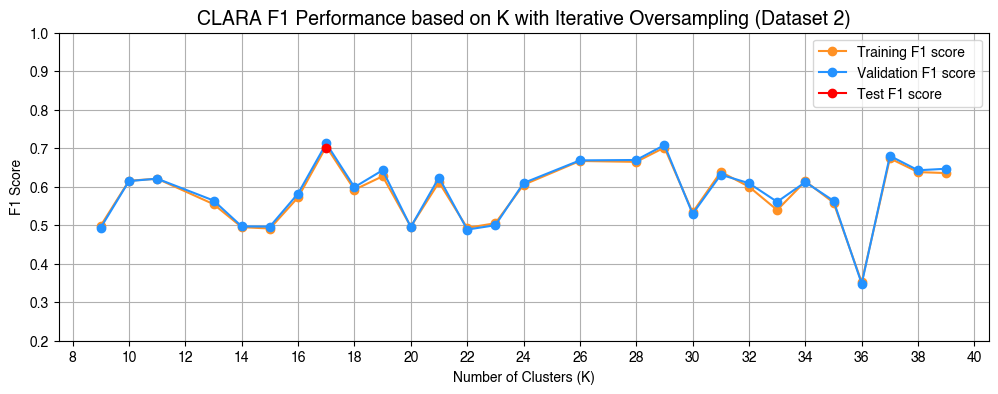

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(train_scores[train_scores['f1_score'] > 0.3]['k'], train_scores[train_scores['f1_score'] > 0.3]['f1_score'], 'o-', color="#ff9124",
         label="Training F1 score")
ax.plot(validation_scores[train_scores['f1_score'] > 0.3]['k'], validation_scores[train_scores['f1_score'] > 0.3]['f1_score'], 'o-', color="#2492ff",
         label="Validation F1 score")
ax.plot(best_k, best_test_score[3], 'o-', color="#ff0000", 
         label="Test F1 score")

ax.xaxis.set_major_locator(plt.MultipleLocator(2));
ax.set_title("CLARA F1 Performance based on K with Iterative Oversampling (Dataset 2)", fontsize=14)
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('F1 Score')
ax.set_ylim(0.2, 1)
ax.grid(True)
ax.legend();

In [20]:
best_test_score

(0.9937105331752558,
 0.6097222222222223,
 0.825187969924812,
 0.7012779552715656,
 0.9627318863657212,
 0.7063493163637227,
 7.24465799331665)

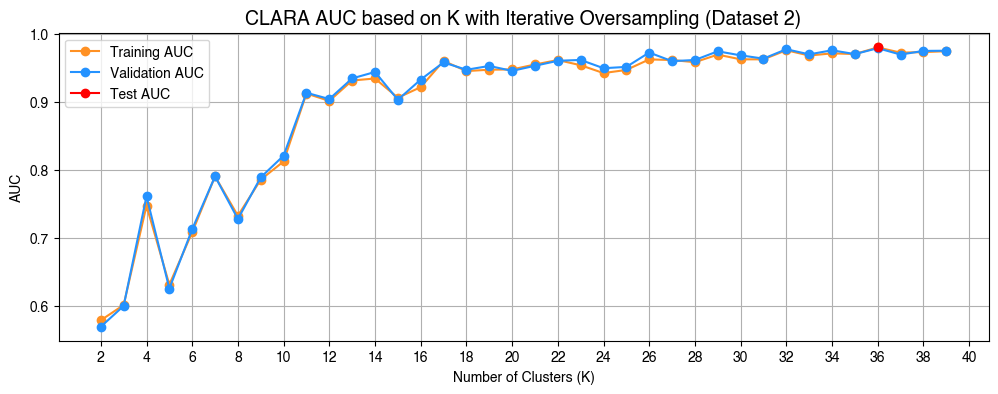

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(train_scores['k'], train_scores['auc'], 'o-', color="#ff9124",
         label="Training AUC")
ax.plot(validation_scores['k'], validation_scores['auc'], 'o-', color="#2492ff",
         label="Validation AUC")
ax.plot(best_k_auc, best_test_score_auc[4], 'o-', color="#ff0000", 
         label="Test AUC")

ax.xaxis.set_major_locator(plt.MultipleLocator(2));
ax.set_title("CLARA AUC based on K with Iterative Oversampling (Dataset 2)", fontsize=14)
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('AUC')
ax.grid(True)
ax.legend();